# Levenberg–Marquardt Estimation

In [2]:
import numpy as np
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

In [3]:
def pend(y, t, params):
    b, c = params['b'], params['c']
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

def g(t, params):
    y0 = [params['y0'], 0.0]
    soln = odeint(pend, y0, t, args=(params,))
    return soln[:,0]

def residual(params, ts, data):
    y0 = [params['y0'], 0.0]
    model = g(ts, params)
    return (model - data).ravel()

In [4]:
true_params = {
          'b': 0.25,
          'c': 5.0,
          'y0': np.pi - 0.1
          }
t = np.linspace(0, 20, 1000)

In [5]:
soln = g(t, true_params)
data = soln + 0.15 * np.random.normal(size=soln.shape)
#data = soln

#plt.plot(t, data, 'k.', alpha=0.55, label='theta(t) noisey')
#plt.plot(t, soln, 'r', label='theta(t)')
##plt.plot(t, data[:, 1], 'g', label='omega(t)')
#plt.legend(loc='best')
#plt.xlabel('t')
#plt.show()

Text(0.5, 0, 't')

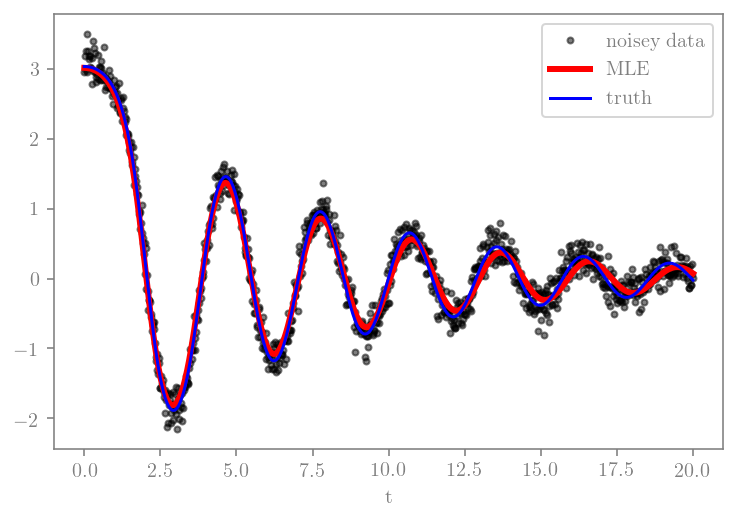

In [6]:
# set parameters incluing bounds
fit_params = Parameters()
fit_params.add('y0', value=float(data[0]), min=0, max=10)
fit_params.add('b', value= 1.0, min=0, max=10)
fit_params.add('c', value= 1.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, fit_params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
plt.plot(t, data, 'k.', alpha=0.5, label='noisey data')
plt.plot(t, final, 'r', linewidth=3, label='MLE');
plt.plot(t, soln, 'b-', label='truth')
plt.legend(loc='best')
plt.xlabel('t')



In [7]:
# display fitted statistics
report_fit(result.params)
print(true_params)

[[Variables]]
    y0:  3.02198726 +/- 0.00116424 (0.04%) (init = 2.963734)
    b:   0.27721849 +/- 0.00240228 (0.87%) (init = 1)
    c:   4.75536203 +/- 0.00151645 (0.03%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(y0, b) =  0.462
{'b': 0.25, 'c': 5.0, 'y0': 3.041592653589793}


# Simplified Drop-Bounce Parameter Estimation

In [42]:
import os, fnmatch, csv
import numpy as np
import pandas as pd
from scipy import signal

# for writing stuff to disk
def load_pickle():
    pass

def dump_pickle(tests):
    pass

def radius(**kwargs):
    """
    Given experimental volume (in mL) the functon returns droplet radius (in m).
    """
    if 'mass' in kwargs.keys():
        pass
    if 'volume' in kwargs.keys():
        vol = kwargs['volume']
        return (3 * vol * 1E-6/(np.pi * 4))**(1/3.) # droplet radius [m]
    
def mass(volume):
    """
    Given experiemental volume (in mL) the function returns mass (in kg).
    """
    return 1000 * volume * 1E-6

def volume(radius_drop):
    """
    Given the radius (in m) returns the volume (in m^3).
    """
    return 4/3*np.pi*radius_drop**3

def import_data(exp_class):
    # parse meta.csv, 
    # columns are name;start;end;volume;surfaceV;frame_rate;outlier;time;debias;first_frame;layers;guess
    meta_file_location = '../data/' + exp_class + '/meta.csv'
    imported_datatype = ('U9', int, int, float, object, 
                         float, bool, float, float, int, 
                         int, float)
    metadata = np.genfromtxt(meta_file_location,
                             delimiter=';',
                             dtype=imported_datatype,
                             names=True)
    for keys, vals in np.ndenumerate(metadata['surfaceV']):
        metadata['surfaceV'][keys] = np.fromstring(vals, dtype=float, sep=',')
    
    # make dict of tests, add test metas
    # structure should be [{'name', 'metas':{}, 'r_data'},...]
    tests = []
    for line in metadata:
        # load raw data
        name = 'd_' + str(line['name'])
        path = '../data/' + exp_class + '/' + str(line['name']) + '.csv'
        data = np.genfromtxt(path, dtype=float, delimiter=',', names=True)
        
        # format sturctured array as dict
        val = line[[b for b in list(line.dtype.names) if b != 'name']]
        key = [b for b in list(line.dtype.names) if b != 'name']
        metas = {key:val for key,val in zip(key,val)}
        
        # calc derived params
        #metas = get_derived_metas(metas)
        
        # check for gaps
        if (data.shape[0]) < data['Slice'][-1]:
            print('{}: there is {} cells of gap'.format(name,
                                                        int((data['Slice'][-1] - data.shape[0]))))
        
        # drop first frame
        first_frame = line['first_frame']
        data = data[first_frame:-1]
        data['Slice'] -= first_frame
        
        # diameter to radius
        data['Minor'] = data['Minor'] / 2
        data['Major'] = data['Major'] / 2
        
        #compose dict from name, metas and raw data
        test = {'name': name,
                'metas': metas,
                'r_data': data,
               }
        
        # get partitioned data
        # format is [{'max', 'data'}, ...]
        bounces, smoothed = partition_bounces(test)
        test['bounces'] = bounces
        test['smoothed'] = smoothed
        
        # append test to list of tests
        tests.append(test)
    return tests

def partition_bounces(test, **kwargs):
    """
    Returns dict containing apoapse index, and smoothed droplet position, 
    velocity, acceleration, and time up to the apoapse for each bounce in the test
    """
    
    def ellipse(data):
        """
        Returns the droplet radius in the vertical direction.
        """
        YM = data['YM']
        a = data['Major']
        b = data['Minor']
        Angle = (data['Angle'] - 90) * np.pi / 180
        return a * b/((b * np.cos(Angle))**2 + (a * np.sin(Angle))**2)**(1/2)

    def ym_0(test, n):
        """
        Returns drop minima and maxima. 
        """
        start, end = test['metas']['start'], -test['metas']['end']
        ym = test['r_data']['YM'][start:end]
        minm = signal.argrelextrema(ym, np.less, order=4)[0][::]
        minm = np.append([0],minm)
        minm = np.append(minm, [len(ym) - 1])
        intstart = minm[n]
        intend = minm[n+1]
        YM_0 = 0 # used in case the reference plane is not the dielectric surface
        return YM_0, intstart, intend, minm

    def contact(test, ym, a, b):
        """
        Returns a mask with elements true where the droplet is not in contact with the surface.
        """
        data = test['r_data']
        contact = ym - ellipse(data[a:b]) * 1 # distance from the bottom of the drop to YM_0
        atol = np.std(ellipse(data[a:b])) * 3
        above_mask = np.invert(np.isclose(contact, 0, atol=atol))
        below_zero_mask = np.invert(np.array([(contact <= 0)]))
        return np.logical_and(above_mask, below_zero_mask).flatten()

    # for each bounces in a test make a smoothed array of t, y, dy, dyy up to apoapse
    a = test['metas']['start']
    b = -test['metas']['end']
    data = test['r_data']
    t = data['Slice'][a:b] / test['metas']['frame_rate']
    ym = data['YM'][a:b]
    dt = t[1] - t[0]
    bounces = []
    n = 0
    while True:
        try:
            YM_0, intstart, intend, minm = ym_0(test, n=n)
        except IndexError:
            break
        # XXX check that ym is always a good represenation of the bounce start
        ym_copy = ym.copy() - YM_0
        contact_mask = contact(test, ym_copy, a, b)
        intendmask = np.array([(t <= t[intend])])
        intstartmask = np.array([(t >= t[intstart])])
        parted_mask = np.logical_and.reduce((intstartmask.flatten(), 
                                             intendmask.flatten(), 
                                             contact_mask))
        if len(ym_copy[parted_mask]) <= 0:
            break
        try:
            y, dy, dyy = sg_filter(ym_copy[parted_mask],dt)
        except StopIteration:
            break
        try:
            maxm = signal.argrelextrema(y, np.greater, order=4)[0][::][0]
        except IndexError:
            maxm = -1
        
        t_copy = t[parted_mask][0:maxm]
        y = y[0:maxm]
        dy = dy[0:maxm]
        dyy = dyy[0:maxm]
        bounce = {'maxm': maxm,
                  'data': pd.DataFrame({
                                      't': t_copy, 
                                      'y': y / 100, 
                                      'dy': dy / 100, 
                                      'dyy': dyy / 100
                                      })
                 }
        bounces.append(bounce)
        n += 1
    
    # make an array of t, y, dy, dyy 
    # for all bounces in a test, individually smoothed
    indices = np.where(contact_mask[1:] != contact_mask[:-1])[0] + 1
    indices[::2] -= 1
    if contact_mask[0] == True:
        indices = np.append(0,indices)
    if contact_mask[-1] == True:
        indices = np.append(indices, len(contact_mask) - 1)
    y = np.array([])
    dy = np.array([])
    dyy = np.array([])
    t_p = np.array([])
    ind_parted = np.array([])
    for keys, vals in np.ndenumerate(indices):
        if keys[0] % 2 == 0 and indices[keys[0] + 1] + 1 - vals >= 10:
            ind_parted_a = len(y)
            y_c, dy_c, dyy_c = sg_filter(ym[vals:indices[keys[0] + 1] + 1], dt)
            y = np.append(y, y_c / 100)
            dy = np.append(dy, dy_c / 100)
            dyy = np.append(dyy, dyy_c / 100)
            t_p = np.append(t_p, t[vals:indices[keys[0] + 1] + 1])
            ind_parted = np.append(ind_parted, [ind_parted_a, len(y) - 1])
    smoothed = (t_p, y, dy, dyy, ind_parted)
    return bounces, smoothed

def sg_filter(y, dt):
    """
    Takes raw data and returns a filtered array of the same length. 
    The function avoids IndexErrors by a simple rule for setting the window size.
    """
    if y.shape[0] > 25:
        window = 25
    else:
        window = y.shape[0]
        if window % 2 == 0:
            window -= 1
        if window < 5:
            window = 5
    if y.shape[0] < window:
        raise StopIteration
    return derivs(y, window, dt)
        
def derivs(y, window, dt):
    """
    Returns Savitsky-Golay filtered array (3 passes) 
    of a variable and its derivatives by finite differences.
    """
    dtdt = dt * dt
    y_savgol = signal.savgol_filter(y, window, 3, deriv=0, axis=0)
    y_savgol1 = signal.savgol_filter(y_savgol, window, 3, deriv=0, axis=0)
    y_savgol2 = signal.savgol_filter(y_savgol1, window, 3, deriv=0, axis=0)
    y_savgol3 = signal.savgol_filter(y_savgol2, window, 3, deriv=0, axis=0)
    dy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=1, axis=0)/dt
    ddy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=2, axis=0)/dtdt
    return y_savgol3, dy_savgol, ddy_savgol


In [43]:
# load data, and make lists of test names
tests = import_data('dielectric_improved')
outlier_names = [test['name'] for test in tests if test['metas']['outlier']==True]
test_names = [test['name'] for test in tests if test['metas']['outlier']==False]

# save results (probably only need to do this once!)
#dump_pickle(tests)

d_07294: there is 2 cells of gap
d_07295: there is 1 cells of gap


In [44]:
# number of bounces in dataset
sum([len(test['bounces']) for test in tests])

42

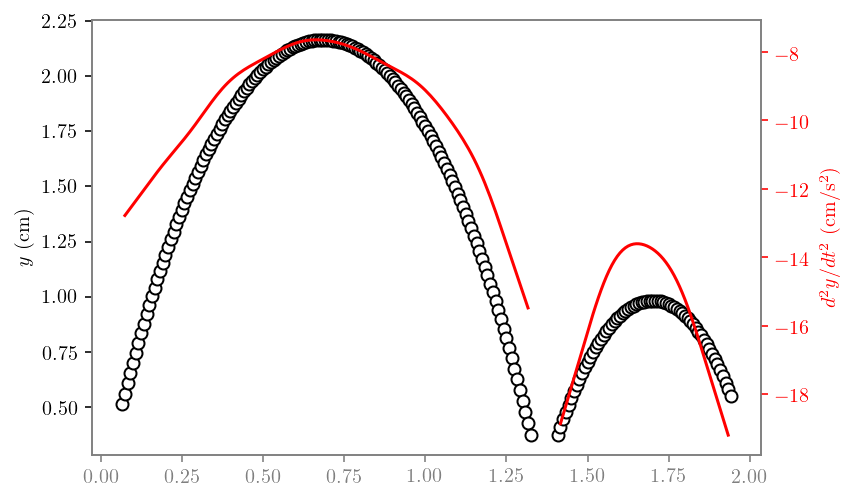

In [45]:
# good place to add a meta for number of bounces to keep
def make_plot(test, bounce_n=0, **kwargs):
    if 'smoothed' in kwargs.keys() and kwargs['smoothed'] == True:
        t, y, dy, dyy, ind = test['smoothed']
        ind = ind.astype(int)
        dy[ind] = None
        dyy[ind] = None
    else:
        df = test['bounces'][bounce_n]['data']
        t, y, dy, dyy = df['t'], df['y'], df['dy'], df['dyy']

    fig, ax1 = plt.subplots()
    color = 'k'
    ax1.tick_params(axis='y', color=color, labelcolor=color)
    ax1.set_ylabel(r'$y$ (cm)', color=color)
    ax1.plot(t, y * 100, color+'o', markersize=6, 
             markerfacecolor='white', markeredgecolor='black')
    ax1.set_xlabel(r'$t$ (s)')

    #ax2 = ax1.twinx()
    #color = 'b'
    #ax2.tick_params(axis='y', color=color, labelcolor=color)
    #ax2.plot(t, dy, color+'-')

    ax3 = ax1.twinx()
    color = 'r'
    ax3.tick_params(axis='y', labelcolor=color, color=color)
    ax3.plot(t, dyy * 100, color+'-')
    ax3.set_ylabel(r'$d^2y/dt^2$ (cm/s$^2$)', color=color)

    plt.show();

#for n in range(len(tests)):
#    make_plot(tests[n], smoothed=True)
make_plot(tests[3], smoothed=True)

In [8]:
import scipy.integrate as integrate
from scipy import stats
import scipy.optimize as opt
import scipy.interpolate as interp

#inputs
d = 6.47 / 100 # dielectric edge length [m]

#physical constants
eta_0 = 8.85E-12       # vacuum permitivity
eta_r = 3.4            # relative permitivity
k = 1/(4 * np.pi * eta_0)  # Coulomb's constant
eta_a=eta_r
susceptibility = eta_a - 1
k = susceptibility/(susceptibility + 2)

def electric_field(end, sigma):
    """
    Returns the 1-D electric field, and the gradient of its square
    in the z-direction of a uniform finite square of charge. (units?)
    """
    
    Ef = np.array([4 * k * sigma * \
                   np.arctan(d**2 / (2 * z * np.sqrt(2 * d**2 + 4 * z**2)))
                   for z in np.linspace(1E-6, end, 10000)])
    return Ef
        
def charge_density(surfaceV, layers):
    return surfaceV * eta_0 * eta_r / ((layers * 2.8 + 5.9) / 1000)

def force_ep(q, Ef):
    """
    Returns the electrophoretic force [N], including the contribution to the 
    attraction of image charges reflected across the dielectric boundary.
    """
    return q * Ef

def force_image(z, q, R_drop):
    susceptibility = eta_r - 1
    k = susceptibility / (susceptibility + 2)
    if z.any() <= 0:
        z[z <= 0] = R_drop
    return 1 / (16 * np.pi * eta_0) * k * q**2 / z**2
    
def drag(v, R_drop):
    """
    Returns the aerodynamic drag force [N].
    """
    def cd(re):
        """
        Drag coefficent, Abraham correlation.
        """
        return 24 / 9.06**2 * (1 + 9.06 / np.sqrt(re))**2
    
    def reynolds(U, R_drop):
        """
        Returns the Reynolds number.
        """
        nu = 15.11E-6
        D = 2 * R_drop
        return D * np.abs(U) / nu
    
    rho = 1.225 # density of air STP
    return cd(reynolds(v, R_drop)) * 2 * rho * np.pi * R_drop**2 * v**2

def fun(y, t, params):
    """
    1-D Equation of motion for a droplet with initial 
    velocity u0 subject to drag, and electrical forces.
    """
    
    z, u = y      # unpack current values of y
    m, R_drop, sigma, q, Ef, zf = params # unpack parameters 
    ef_interp = np.interp(z, zf, Ef)
    # list of dy/dt=f functions
    derivs = [u, (- force_ep(q, ef_interp) \
                  - force_image(z, q, R_drop) \
                  - drag(u, R_drop)) / m]
    return derivs

def get_model(x, model_params):
    """
    Solves the ODE for the droplet trajectory given the design vector, x.
    """
    t0, z0, volt0, vol0, tStop, layers, q0, Ef, zf = model_params
    surfaceV, volume, q, u0 = x  
    m = mass(volume)                                # droplet mass [kg]
    R_drop = radius(volume=volume)                  # droplet radius
    sigma = charge_density(surfaceV, layers)
    
    # Initial values
    z0 = z0    # initial displacement
    u0 = u0    # initial velocity
    t0 = t0    # initial time

    # Bundle parameters for ODE solver
    params = (m, R_drop, sigma, q, Ef, zf)
    
    # Bundle initial conditions for ODE solver
    y0 = [z0, u0]

    # Make time array for solution
    tInc = 0.00001
    t_rk = np.arange(t0, tStop, tInc)

    # Call the ODE solver
    psoln = integrate.odeint(fun, y0, t_rk, args=(params,), mxords=5)
    return psoln, t_rk

def get_params(drop, a=3.5, **kwargs):
    """
    Gets experimental parameters from drop object.
    """
    layers = drop.layers
    surfaceV = np.mean(drop.surfaceV)              # superhydrophobic surface potential
    volume = drop.volume                           # droplet volume
    if hasattr(drop, 'guess'):
        q = drop.guess * 1E-12 * volume * surfaceV
    else:
        q = a * 1E-12 * volume * surfaceV                # wild-ass guess droplet net charge [C]
    if 'test' in kwargs.keys() and kwargs['test']==True:
        q = a * 1E-12 * volume * surfaceV
    sigma = charge_density(surfaceV, layers)
    t, y, dy, ddy = get_data(drop, param_est=True)
    t0 = t[0]                                       # droplet initial time
    y0 = y[0]                                       # droplet initial position
    dy0 = dy[0]                                     # droplet initial y-velocity
    return surfaceV, volume, q, sigma, t0, y0, dy0, layers  #remove sigma, m, R_drop

def get_constraints(drop):
    """
    Gets the minimization problem constraints from the experimental 
    measurement error for each parameter.
    """
    
    constraints = {'volume': 0.02,      # [m^3]
                    'q': None,
                    't0': 1 / 120.,       # [s]
                    'y0': 0.02 / 100,     # [m]
                  }
    y, t, dy, ddy = get_data(drop, param_est=True)
    y = y
    dy = dy
    constraints.update({'dy0': dy[0] * \
                        np.sqrt(1 + (constraints['y0'] / (y[1] - y[0]))**2)})
    if np.std(drop.surfaceV) > 0.:
        constraints.update({'surfaceV': np.std(drop.surfaceV) \
                            + np.mean(drop.surfaceV) * 0.2}) # [V]
    else:
        constraints.update({'surfaceV': 100. + np.mean(drop.surfaceV) * 0.2})
    return constraints

def obj_func(x, *args):
    """
    Pseudo-objective function with box bound constraints handles by 
    exterior penalty function. The function to be 
    minimized is the chi2 goodness of fit between the experimental and 
    model trajectories given the parameter
    estimates (e.g. the design vector), x.
    """
    
    exp_data, model_params, constraints = args
    surfaceV, volume, q, dy0 = x 
    t, y, dy, ddy = exp_data
    yStop = y[-1] + 10 * (y[-1] - y[-2])
    layers = model_params[5]
    sigma = charge_density(surfaceV, layers)
    Ef = electric_field(yStop, sigma)
    zf = np.linspace(1E-6, yStop, 10000)
    model_params = model_params + (Ef, zf)
    psoln, t_rk = get_model(x, model_params)
    #psoln = psoln[:,0]*100
    #b = interp.interp1d(np.arange(psoln.size),psoln)
    #y_soln = b(np.linspace(0,psoln.size-1,len(t)))
    y_soln = np.array([])
    for times in t:
        y_soln = np.append(y_soln, np.interp(times, t_rk, psoln[:,0]))
        
    rp = 50  
    penalty = rp * ( max(0,  volume/(model_params[3] + constraints['volume']) - 1)**2 
                    + max(0, -volume/(model_params[3] - constraints['volume']) + 1)**2
                    + 0.80 * max(0,  surfaceV/(model_params[2] + constraints['surfaceV']) - 1)**2 
                    + 0.80 * max(0, -surfaceV/(model_params[2] - constraints['surfaceV']) + 1)**2
                    + max(0, -q/(model_params[6]))**2)
    return np.log(stats.chisquare(y,f_exp=y_soln,axis=0)[0]) + penalty
        
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global sim
    sim.append(p)
    
def res(drop, a, **kwargs):
    """
    Returns the parameter estimates of the drop experiment.
    """
    global sim
    exp_data = get_data(drop, param_est=True)
    constraints = get_constraints(drop)
    surfaceV, volume, q, sigma, t0, y0, dy0, layers = get_params(drop, a)
    model_params = (t0, y0, surfaceV, volume, exp_data[0][-1], layers, q)
    X0 = np.asarray((surfaceV, volume, q, dy0))
    sim = [X0]
    args = (exp_data, model_params, constraints)
    result = opt.minimize(obj_func, X0, args=args, 
                          method='nelder-mead', options={'maxiter':300}, callback=reporter)
    fsim = np.exp(np.array([obj_func(x, *args) for x in sim]))
    result.fun = np.exp(result.fun)
    #final_fsim = np.array([obj_func2(x, *args) for x in result.final_simplex[0]])
    #try:
    #    error = _neldermead_errors(np.divide(result.final_simplex[0],X0), \
    #                                         final_fsim, obj_func2, X0, *args)
    #except AssertionError:
    #    error = 'fail'
    error = False
    return result, sim, fsim, error

In [9]:
k

0.5454545454545454

In [ ]:
# define ODE model
# params are q, V_d, sigma, t0, y0


# do the parameter estimation (using arbitrary fit function)
def fit():       
    fit_params = Parameters()
    for params in test.params:
        fit_params.add(param_name, val, min, max)
    test['result'] = minimize(residual, fit_params, args=(t, data), method='leastsq')


# do param est for all tests
for test in list_of_tests:
    for bounce in test['bounces']:
        result = fit(bounce)
        # add result to bounce
        bounce['result'] = result


# pickle results (write results to disk)
for test in list_of_tests:
    pickle test['result']


# do post-processing in seperate notebook, add vizualization to check results
# make plot of data vs. ODE soln given est. params
def viz_single_test(test, bounce):
    data, results = test.data, test.result
    final = data + result.residual.reshape(data.shape)
    plot(t, data)
    plot(t, final)


test = XXX
bounce = 1
#viz_single_test(test, bounce)
